*This notebook, `summary.ipynb`, contains analysis of the open-coding processes itself. It depends upon CSV files generated by `notebook-search.ipynb`.*

# Import data and modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from lib.util import getCodes, displayMarkdown

%autosave 0

Autosave disabled


## Import codes

The cell below recursively searches the `notebooks/` directory for files with a `.html.pdf` extension. These are PDF printouts of computational notebooks and scripts that I coded using the comments feature in [Adobe Acrobat DC](https://acrobat.adobe.com/ca/en/acrobat.html). This notebook needs to import all codes from the open coding process.

In [2]:
%%time
codes = getCodes()

CPU times: user 55.8 s, sys: 260 ms, total: 56 s
Wall time: 56.5 s


## Import metadata on analyzed notebooks

The cell below parses the works-cited section of the `README.md` document with regular expressions. A demo of this regular expression can be found on [regexr.com](https://regexr.com/4htcn). This section contains a citation for every notebook included in this analysis. Some of the URLs from the works cited list are cleaned so that the path matches the path in this repository under `notebooks/`.

In [85]:
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([^\*]+)\*\.\sRetrieved from https:\/\/(?:[^\/]+\/){2}(.*)\n'
with open('README.md') as readme:
    content = readme.read()

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'path'])

citations.replace(to_replace=r'data/tree/master/|data-projects/tree/master/|2016/05/|st-methods/tree/master/', 
                  value='', 
                  regex=True, 
                  inplace=True)

citations.head()

,journalist,year,month,date,article,organization,path
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,2016-09-shy-trumpers
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,buster-posey-mvp
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Vox,verge-uber-launch-dates
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,electric-car-charging-points
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,internal-migration-london


## Import repos and contributors

The file `notebook-search.ipynb` mines GitHub for repos containing data-journalism workflows and exports this data to `data/repos.csv` and `data/contributors.csv`.

In [132]:
# Get all repos
repos = pd.read_csv('data/repos.csv')

# Subset repos to only those that contained data analysis
keepers = repos[repos.is_keeper == True]

# Get contributors, which is really contributors to keeper notebooks
contributors = pd.read_csv('data/contributors.csv')

# Analysis Stats

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,30
organization,25
article,46
codes,151
repos,181
relevant repos,181
total organizations,38


# Establishing convergence
TK

## Notebook coding order

The works cited page of analyzed computational notebooks serves as a list of coded notebooks, but it doesn't preserve the order in which they were coded. The `reposIncluded` list has lists each repo in reverse chronological order.

In [6]:
pathsIncluded = [
    'swana-population-map',
    '1805-regionen im fokus des US-praesidenten',
    'school-choice',
    '201901-achievementgap',
    'general-election-2015-classification-tree',
    '201901-hospitalquality',
    'awb-notebook',
    'skatemusic',
    'new-york-schools-assessment',
    'lending-club',
    'auditData',
    '2019-ems-analysis',
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'the-cube-root-law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat-index',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-ccscore-analysis',
    '2019-04-democratic-candidate-codonors',
]

codingOrder = pd.DataFrame({'article': pathsIncluded[::-1] }).reset_index().rename(columns={'index': 'coding order'})

### Sanity check

Make sure that I've manually added all the repos to `reposIncluded` that are listed in `README.md`.

In [7]:
citMinusPath = set(citations.path.unique()).difference(set(pathsIncluded))
pathMinusCit = set(pathsIncluded).difference(set(citations.path.unique()))

if len(citMinusPath) > 0:
    displayMarkdown('In `citations` but not in `pathsIncluded`: {}'.format(', '.join(list(citMinusPath))))
else:
    displayMarkdown('All paths in `citations` are also in `pathsIncluded`\n')

if len(pathMinusCit) > 0:
    displayMarkdown('In `pathsIncluded` but not in `citations`: {}'.format(', '.join(list(pathMinusCit))))
else:
    displayMarkdown('All paths in `pathsIncluded` are also in `citations`\n')

All paths in `citations` are also in `pathsIncluded`


All paths in `pathsIncluded` are also in `citations`


## Visualizing code set growth

In order to visualize the cardinality of the code set per notebook coded, the `codes` data frame needs to be grouped by article.

In [8]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,7,2019-04-democratic-candidate-codonors,"[use open government data, read as tabular dat...",0,28,"change case, count value frequency, gather tab..."
1,19,california-ccscore-analysis,"[format table display, read as tabular data, s...",1,43,"export results, drop duplicate rows based on v..."
2,20,california-crop-production-wages-analysis,"[use open government data, format table displa...",2,50,"architect repeating process, construct table m..."
3,22,census-hard-to-map-analysis,"[wrangle data for graphics, use open governmen...",3,52,"slice column values, tolerate dirty data"
4,32,long-term-care-db,"[count value frequency, calculate scaled ratio...",4,63,"perform entity resolution manually, drop erron..."


Plot the size of the code set as more computational notebooks are analyzed.

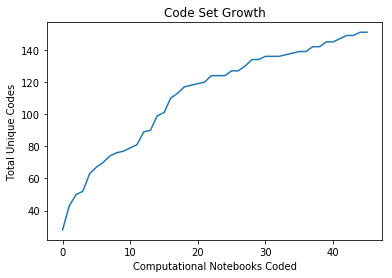

In [9]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

For each notebook included in analysis list which codes were introduced to the code set. After 23 notebooks, some computational notebooks didn't add any new codes.

In [10]:
for i, row in codesByArticle.iterrows():
    displayMarkdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes']))

1. **2019-04-democratic-candidate-codonors**: change case, count value frequency, gather table, sum along dimension, count unique values in column, annotate workflow, peek at data, self join table, architect a subroutine, union tables, calculate ratio, canonicalize column names, remove with regular expression, use open government data, outer join tables, strip whitespace, group by single column, create a semi-unique key, repetitive code, sort table, drop duplicate rows based on prior knowledge, read as tabular data, calculate scaled ratio, trim by contains value, subset columns, compare different groups along a common metric, group by multiple columns, export intermediate results

2. **california-ccscore-analysis**: export results, drop duplicate rows based on values, count number of rows, create a crosstab, trim by quantitative threshold, inspect table schema, change column data type, split, compute, and merge, calculate percentage difference, calculate difference, calculate mean, calculate z-score, trim by date range, visualize data, format table display

3. **california-crop-production-wages-analysis**: architect repeating process, construct table manually, adjust for inflation, wrangle data for graphics, inner join tables, answer a question, trim by geographic area

4. **census-hard-to-map-analysis**: slice column values, tolerate dirty data

5. **long-term-care-db**: perform entity resolution manually, drop erroneous rows, scrape web for data, fix data errors manually, use non-public, provided data, construct pivot table, fill in na values after an outer join, encode table identification in row, join with lookup table, aggregate the forest from the trees, refine table

6. **2018-voter-registration**: create rolling window, pull tables out of pdf, show trend over time, calculate a statistic

7. **heat-index**: generate data computationally, compute index number, cartesian product

8. **2016-11-bellwether-counties**: get extreme values, remove incomplete data, use academic data, spread table

9. **2018-05-31-crime-and-heat-analysis**: extract property from datetime, combine seemingly disparate datasets

10. **2016-09-shy-trumpers**: use another news orgs data

11. **the-cube-root-law**: wtf, use public data

12. **2016-04-republican-donor-movements**: explore dynamic network flow, split column on delimiter

13. **california-h2a-visas-analysis**: replace na values, create child table, create a unique key, preserve existing values, split and compute, geocode addresses, cache results from external service, temporary joining column

14. **Endangered-Species-Act-Louisiana**: transform vector

15. **Power_of_Irma**: use data from colleague, value replacement, change date format, fix incorrect calculation, toggle step on and off, set data confidence threshold, outlier detection, interpret statistical/ml model, use previously cleaned data

16. **wikipedia-rankings**: explain variance, collect raw data

17. **babyname_politics**: break ties, data loss from aggregation, round floating point, resort after merge, assign ranks, concatenate columns into key, get unique values, join aggregate, check results of previous operation

18. **2015-11-refugees-in-the-united-states**: test for equality, designate column as primary key, make an incorrect conclusion

19. **employment-discrimination**: merge tables to create pivot table, combine entities by string matching, concatenate files together, align table columns for consolidation

20. **bechdel**: calculate median

21. **bob-ross**: whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: translate entity names manually, create flag, copy table schema, data too large for repo

24. **buster-posey-mvp**: 

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: correct bad formatting, sort table rows, report rows with column number discrepancies

27. **prison-admissions**: 

28. **school-star-ratings-2018**: display rows with missing values, reconcile primary keys between tables, pad column values

29. **electric-car-charging-points**: find nearest neighbours in the network, create edge, define edge weights, encode redundant information

30. **internal-migration-london**: 

31. **midwife-led-units**: freedom of information data, test different computations for equality

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: resolve to arbitrary entity name among choices

35. **2019-ems-analysis**: combine data and geography

36. **auditData**: combine columns

37. **lending-club**: 

38. **new-york-schools-assessment**: combine drifting datasets, backfill missing data, create lookup table

39. **skatemusic**: 

40. **awb-notebook**: summarize dataset, silently dropping values after groupby, resolve by substring

41. **201901-hospitalquality**: 

42. **general-election-2015-classification-tree**: wrangle data for model, check for nas

43. **201901-achievementgap**: bin values, query database

44. **school-choice**: 

45. **1805-regionen im fokus des US-praesidenten**: compute an inter-table column, concat parallel tables

46. **swana-population-map**: 

# Analysis Coverage

In order to prevent this code set from being biased by one individual or organization's data wrangling behavior, we deliberately sought out notebooks from a variety of news organizations and data journalists. This analysis comes from, but is not limited to, news organizations that constitute "major players" in data journalism. 

## Including the top-n news organizations

We ranked these organizations by two metrics: those with the most separate repositories and the most Git commits among all repos.

In [139]:
orgs = repos[repos.is_keeper == True] \
    .groupby('org') \
    .agg({
        'url': 'nunique',
        'commits': 'sum'
    }) \
    .reset_index() \
    .rename(columns={
        'org': 'organization', 
        'url': 'repo_count',
        'commits': 'commit_count'
    })

# Assign ranks to each organization per repo count and commit count
def rank(df, sort_col, rank_col):
    df.sort_values(sort_col, ascending=False, inplace=True)
    df[rank_col] = df.reset_index().index + 1

rank(orgs, 'repo_count', 'repo_rank')
rank(orgs, 'commit_count', 'commit_rank')

# Find which organizations have been included in analysis
includedOrgs = list(citations.organization.unique())
orgs['is_included'] = False
orgs.loc[orgs.organization.isin(includedOrgs), 'is_included'] = True

# Ok, so what did I do?
orgs.head()

,organization,repo_count,commit_count,repo_rank,commit_rank,is_included
10,FiveThirtyEight,1,907,36,1,True
0,Austin American-Statesman,11,277,3,2,True
3,Baltimore Sun,12,277,2,3,True
4,BuzzFeed News,77,242,1,4,True
34,TrendCT,4,164,10,5,True


### Top by number of repos

Most news organizations, including *BuzzFeed News*, *Los Angeles Times*, and the *Austin American-Statesman*, create one repo per analysis work flow.

Text(0.5, 1.0, 'News Organizations Ranked by Number of Repos')

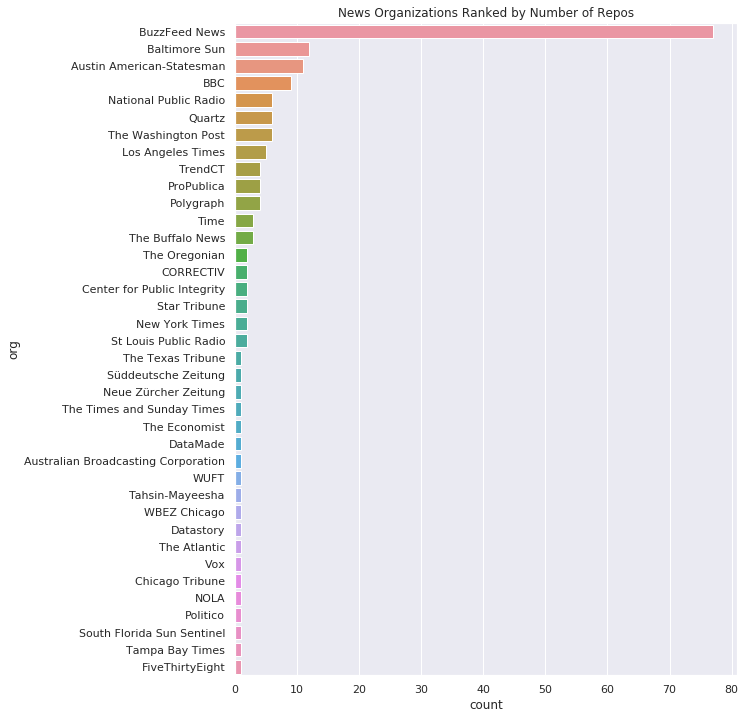

In [12]:
sns.set(rc={'figure.figsize': (9,12)})
ax = sns.countplot(y='org',
              data=repos[repos.is_keeper],
              order=repos[repos.is_keeper].org.value_counts().index)  # Plot in descending order

ax.set_title('News Organizations Ranked by Number of Repos')

In [13]:
displayMarkdown("""
    This analysis includes the top {} organizations by repo count.
""".format(orgs[orgs.is_included == False].repo_rank.min() - 1))


    This analysis includes the top 19 organizations by repo count.


### Top by number of commits

However, one limitation of ranking news organizations by repo count is that some organizations, such as *FiveThirtyEight* keep computational notebooks for multiple data journalism articles in one repo.

A *commit* in Git can be thought of as a unit of change for a repo. Thus the more a repo has changed overtime, the more commits. If a news organization is only using one repo for all their data journalism work, then it should have lots of commits.

Text(0.5, 1.0, 'Most Prolific News Organizations by Number of Commit')

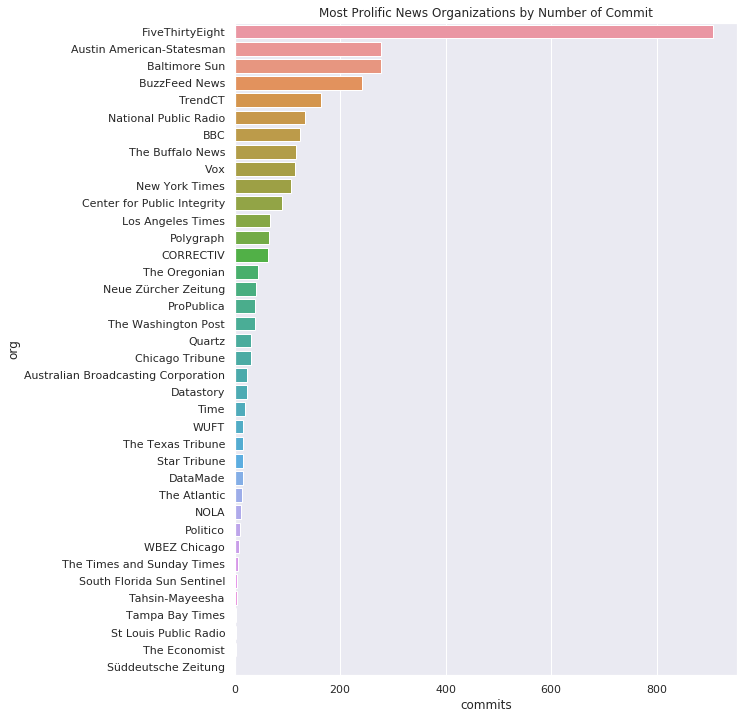

In [14]:
#contributors = pd.read_csv('data/contributors.csv')
#repos = pd.merge(repos, contributors, on='url', how='left')

sns.barplot(x='commits',
            y='org', 
            data=repos.groupby('org')['commits'].sum().to_frame('commits').reset_index() \
            .sort_values('commits', ascending=False) \
            .head(50)) \
    .set_title('Most Prolific News Organizations by Number of Commit')

In [15]:
displayMarkdown("""
    This analysis includes the top {} organizations by commit count.
""".format(orgs[orgs.is_included == False].commit_rank.min() - 1))


    This analysis includes the top 18 organizations by commit count.


### Which organizations were included?

In [16]:
included_count = sum(orgs.is_included)
total_orgs = len(orgs.organization.unique())

displayMarkdown("""
This analysis includes {included_count} out of {total} ({percent}%) organizations: \n * {list}
""".format(**{
    'included_count': included_count,
    'total': total_orgs,
    'percent': round((included_count / total_orgs) * 100, 2),
    'list': '\n * '.join(sorted(orgs[orgs.is_included == True].organization.unique()))
}))


This analysis includes 25 out of 38 (65.79%) organizations: 
 * Austin American-Statesman
 * BBC
 * Baltimore Sun
 * BuzzFeed News
 * CORRECTIV
 * Center for Public Integrity
 * FiveThirtyEight
 * Los Angeles Times
 * NOLA
 * National Public Radio
 * Neue Zürcher Zeitung
 * New York Times
 * Polygraph
 * ProPublica
 * Quartz
 * St Louis Public Radio
 * Star Tribune
 * The Buffalo News
 * The Oregonian
 * The Times and Sunday Times
 * The Washington Post
 * Time
 * TrendCT
 * Vox
 * WUFT


## Including the top-n data journalists

The first step is to split (a.k.a explode) rows in the `citations` data frame that represent collaborative data journalism projects done by multiple journalists into separate rows. I've separated multiple authors in the citations with semicolons.

In [86]:
citations[citations.journalist.str.contains(';')]

,journalist,year,month,date,article,organization,path
20,"Keller, Josh; Pearce, Adam",2016,September,7,US State prison admissions by county.,New York Times,prison-admissions
24,"Menezes, Ryan; Stevens, Matt; Welsh, Ben",2016,October,31,"California ""Conservation-Consumption Score"" an...",Los Angeles Times,california-ccscore-analysis


In [98]:
citationsUnpacked = pd.DataFrame(list(citations.journalist.apply(lambda name: name.split(';'))),
            index=citations.path).stack().to_frame().reset_index([0, 'path']) \
    .rename(columns={0: 'journalist'})

citationJournalists = pd.merge(citationsUnpacked, citations.drop(['journalist'], axis=1), on='path', how='left')
citationJournalists['name'] = citationJournalists.journalist.apply(lambda name: "{} {}".format(*name.split(', ')[::-1]))
citationJournalists['is_cited'] = True
citationJournalists = citationJournalists[['name', 'is_cited']].drop_duplicates()
citationJournalists.head()

,name,is_cited
0,Peter Aldhous,True
1,Rob Arthur,True
2,Frank Bi,True
3,Paul Bradshaw,True
6,Stefano Ceccon,True


Modify the `citations` data frame so that it has a primary key to join the `contributors` data frame. The `journalist` column in `citations` is formatted as "given name, surname", so I'll swap those around.

From the `contributors` data frame, we can get a sense of the "top" data journalists based on how many commits they've made and the number of followers of their GitHub user account.

In [140]:
# Fun fact, this is an example of aggregate join
dataJournalists = pd.merge(
    contributors[['login', 'name']],
    contributors.groupby('login').agg({'followers': max, 'commits': sum }).reset_index(),
    on='login') \
    .drop_duplicates()

# Combine to get a data frame of journalists included and not included in analysis
dataJournalists = pd.merge(dataJournalists, citationJournalists, how='left', on='name')
dataJournalists.is_cited.fillna(False, inplace=True)

rank(dataJournalists, 'followers', 'follower_rank')
rank(dataJournalists, 'commits', 'commits_rank')

dataJournalists.head()

,login,name,followers,commits,is_cited,follower_rank,commits_rank
77,dmil,Dhrumil Mehta,266,419,False,16,1
22,andrewbtran,Andrew Tran,99,159,True,30,2
123,carlmjohnson,Carl Johnson,43,144,False,61,3
9,jsvine,Jeremy Singer-Vine,562,126,True,5,4
78,andrewflowers,Andrew Flowers,309,114,True,13,5


### Top data journalists by commits

### Top data journalists by followers

Text(0.5, 1.0, 'Most Popular Data Journalists by GitHub Followers')

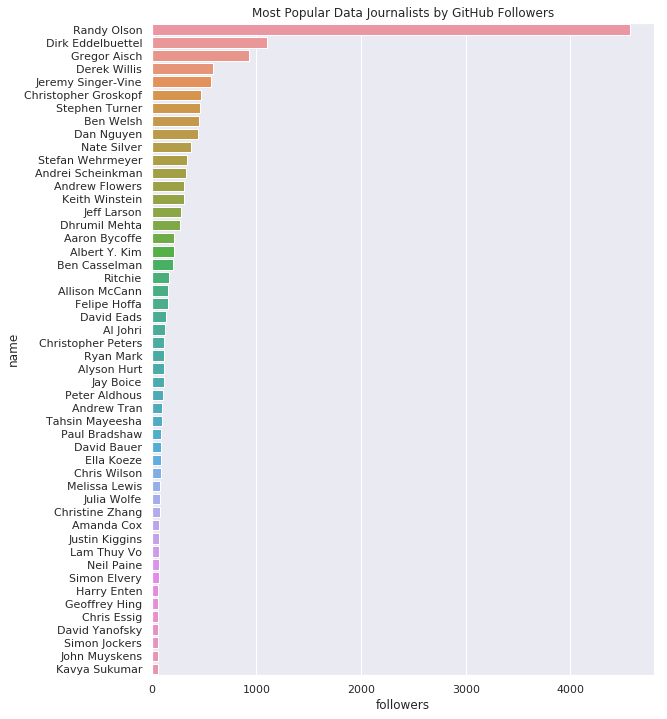

In [116]:
sns.barplot(x='followers',
            y='name', 
            data=dataJournalists \
            .sort_values('followers', ascending=False) \
            .head(50)) \
    .set_title('Most Popular Data Journalists by GitHub Followers')

In [143]:
displayMarkdown("""
    This analysis includes the top {} data journalists by GitHub followers.
""".format(dataJournalists[dataJournalists.is_cited == False].follower_rank.min() - 1))


    This analysis includes the top 0 data journalists by GitHub followers.


Text(0.5, 1.0, 'Most Prolific Data Journalists by Commits')

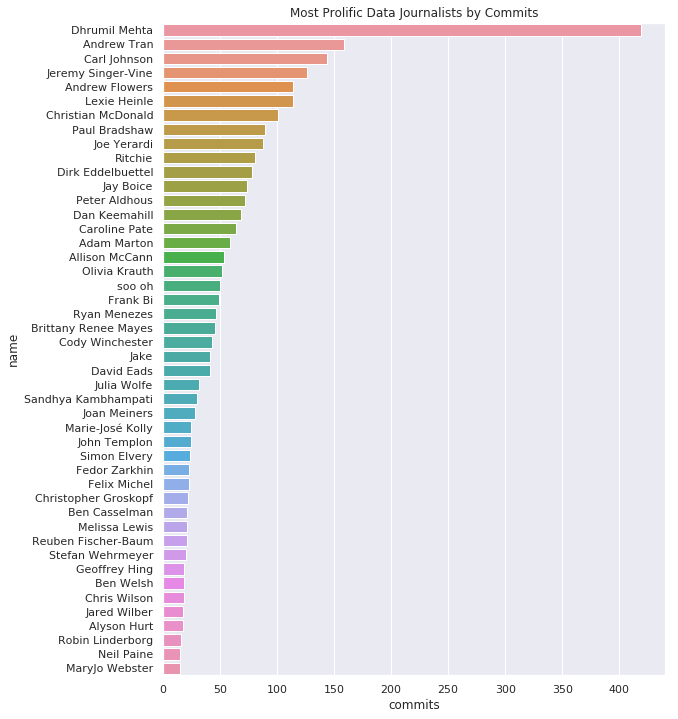

In [115]:
sns.barplot(x='commits',
            y='name', 
            data=dataJournalists \
            .sort_values('commits', ascending=False) \
            .head(50)) \
    .set_title('Most Prolific Data Journalists by Commits')

In [144]:
displayMarkdown("""
    This analysis includes the top {} data journalists by commits.
""".format(dataJournalists[dataJournalists.is_cited == False].commits_rank.min() - 1))


    This analysis includes the top 0 data journalists by commits.
